# import libraries and downloading data

In [1]:
!pip install equinox
!pip install kaggle
!pip install -q flax
import equinox
from flax.training import train_state
import flax.linen
from flax import serialization
import jax
import optax
import matplotlib
import os
import PIL.Image
import PIL.ImageEnhance
import math
import random
import numpy
from typing import Sequence, List, Tuple
import torch
import time
import pickle
import gc
import json
import flax
import shutil

In [2]:
def get_base_dir(preferred=None):
  if preferred:
    return preferred
  env_dir = os.getenv("BASE_DIR")
  if env_dir:
    return env_dir
  if os.path.exists("/kaggle/working"):
    return "/kaggle/working"
  if os.path.exists("/content"):
    return "/content"
  return os.getcwd()
BASE_DIR = get_base_dir(preferred=r"C:\Users\zshua\Downloads\deeplearningproject\content")
DATA_DIR = os.path.join(BASE_DIR, "data")
KAGGLE_JSON_PATH = os.path.join(BASE_DIR, "kaggle.json")
def bpath(*parts):
  return os.path.join(BASE_DIR, *parts)
def data_path(*parts):
  return os.path.join(DATA_DIR, *parts)
print(f"BASE_DIR: {BASE_DIR}")
print(f"DATA_DIR: {DATA_DIR}")

BASE_DIR: C:\Users\zshua\Downloads\deeplearningproject\content
DATA_DIR: C:\Users\zshua\Downloads\deeplearningproject\content/data


# code will not run if you don't provide kaggle login!

In [3]:
'''
if not os.path.exists(KAGGLE_JSON_PATH):
  from google.colab import files
  uploaded = files.upload()
'''
os.makedirs(os.path.expanduser("~/.config/kaggle"), exist_ok=True)
try:
  shutil.copyfile(KAGGLE_JSON_PATH, os.path.expanduser("~/.config/kaggle/kaggle.json"))
  try:
    os.chmod(os.path.expanduser("~/.config/kaggle/kaggle.json"), 0o600)
  except Exception:
    pass
except Exception as e:
  print("Could not copy kaggle.json to config dir:", e)

Could not copy kaggle.json to config dir: [Errno 2] No such file or directory: 'C:\\Users\\zshua\\Downloads\\deeplearningproject\\content/kaggle.json'


In [4]:
import kaggle #sometimes doesn't work if we import kaggle a the very start so bear with the ugly placement
kaggle.api.authenticate()

In [5]:
sample_data_path = bpath('sample_data')
if os.path.exists(sample_data_path):
  import shutil
  shutil.rmtree(sample_data_path)
#dont mind this, this was for before when we placed the data into a sample_data to quickly manipulate the images

Download and inspect a Kaggle wound dataset, checking image sizes, label distribution, and metadata

In [6]:
# Download Wound dataset from Kaggle if not present; support different base paths
wound_dataset_dir = data_path('Wound_dataset copy')
if not os.path.exists(wound_dataset_dir): # just in case since we might be using run all out of pure laziness a couple of times
  kaggle.api.dataset_download_files("ibrahimfateen/wound-classification", path=DATA_DIR, unzip=True)

In [7]:
base_path = BASE_DIR
print(f"Base path is: {base_path}")

Base path is: C:\Users\zshua\Downloads\deeplearningproject\content


In [8]:
label_counts = {}
size_counts = {}
image_info = []
root_wound_dir = data_path('Wound_dataset copy')
for label in os.listdir(root_wound_dir):
  label_path = os.path.join(root_wound_dir, label)
  if not os.path.isdir(label_path):
    continue
  for filename in os.listdir(label_path):
    if not filename.lower().endswith((".jpg")):
      continue
    filepath = os.path.join(label_path, filename)
    try:
      with PIL.Image.open(filepath) as img:
          w, h = img.size
    except Exception as e:
      print("Cannot find the file", filepath, e)
      continue
    if label not in label_counts:
      label_counts[label] = 0
    label_counts[label] += 1
    key = (w, h)
    if key not in size_counts:
      size_counts[key] = 0
    size_counts[key] += 1
    image_info.append({
      "path": filepath,
      "label": label,
      "width": w,
      "height": h,
    })
print(label_counts)
print(list(size_counts.items())[:2])


{'Normal': 100, 'Cut': 50, 'Laseration': 61, 'Bruises': 121, 'Diabetic Wounds': 231, 'Surgical Wounds': 210, 'Pressure Wounds': 301, 'Burns': 67, 'Abrasions': 82, 'Venous Wounds': 247}
[((119, 126), 1), ((135, 113), 1)]


In [9]:
dataset_path = data_path('Wound_dataset copy')
mirrored_files = []
total_files = 0
for root, directories, files in os.walk(dataset_path):
  for file in files:
    total_files += 1
    if 'mirrored' in file.lower():
      mirrored_files.append(os.path.join(root,file))
#checking for files that haved mirrored inside of them, since from testing, we got higher accuracy when we removed mirrored files (im not sure why, but usually it's bad for a dataset to have multiple copies of the same data)
print(total_files)
print(len(mirrored_files))


1470
0


In [10]:
what_deleted = []
deleted_count = 0
for root, directiories, files in os.walk(dataset_path):
  for file in files:
    if file.startswith('mirrored'):
      file_path = os.path.join(root,file)
      os.remove(file_path)
      what_deleted.append(file_path)
      deleted_count += 1
print(deleted_count)
print(what_deleted)

0
[]


In [11]:
mirrored_files = []
total_files = 0
for root, directories, files in os.walk(dataset_path):
  for file in files:
    total_files += 1
    if 'mirrored' in file.lower():
      mirrored_files.append(os.path.join(root,file))
#check again
print(total_files)
print(len(mirrored_files))

1470
0


In [12]:
os.makedirs(data_path('dataset'), exist_ok=True)
#renaming files so it's based on the label and index, and moving them into a dataset folder within data
index = 1
root_wound_dir = data_path('Wound_dataset copy')
for label in os.listdir(root_wound_dir):
  label_path = os.path.join(root_wound_dir, label)
  if not os.path.isdir(label_path):
    continue
  for filename in os.listdir(label_path):
    if not filename.lower().endswith(".jpg"):
      continue
    source_path = os.path.join(label_path, filename)
    safe_label = label.replace(" ","_")
    new_name = f"{index:06d}_{safe_label}.jpg"
    destination_path = os.path.join(data_path('dataset'), new_name)
    with open(source_path,"rb") as filesource:
      data = filesource.read()
    with open(destination_path, "wb") as filedestination:
      filedestination.write(data)
    index +=1


In [13]:
unique_sizes = set()
dataset_dir = data_path('dataset')
for filename in os.listdir(dataset_dir):
  if not filename.lower().endswith(".jpg"):
    continue
  fpath = os.path.join(dataset_dir, filename)
  try:
    with PIL.Image.open(fpath) as image:
        w, h = image.size
  except Exception as e:
    print("Error reading", fpath, e)
    continue
  unique_sizes.add((w, h))
print(len(unique_sizes))
for w, h in sorted(unique_sizes):
  print(w, h)


585
61 78
66 86
73 85
75 89
76 76
77 87
78 78
78 82
79 79
79 80
80 80
83 82
83 93
84 75
85 85
85 86
85 89
86 95
87 95
89 89
89 109
90 89
90 90
90 107
91 90
91 91
91 92
92 85
92 88
92 93
93 89
93 93
93 100
94 80
95 67
95 91
95 95
97 96
97 98
97 103
98 98
99 98
99 99
100 99
100 100
100 116
100 122
101 101
101 102
102 102
102 105
102 106
102 125
103 120
104 103
104 104
105 97
105 105
105 113
105 120
106 105
106 106
106 112
107 107
108 108
109 109
110 110
110 111
111 111
111 112
112 106
112 111
112 112
113 98
113 113
116 116
116 118
117 109
117 117
118 108
118 110
118 118
119 118
119 119
119 126
120 128
121 87
121 116
121 121
121 122
121 129
122 111
122 122
122 123
123 106
123 122
123 123
124 114
124 124
125 121
125 125
125 141
125 146
126 105
126 126
126 149
127 107
127 127
128 110
128 122
128 128
128 139
128 182
129 122
129 130
130 104
130 113
130 114
130 130
130 131
130 132
131 125
131 131
132 115
132 132
132 167
133 112
133 118
133 132
133 133
134 134
134 143
134 144
134 149
135 113
13

In [14]:
def preprocess_folder(destination_directory,target_size):
  os.makedirs(destination_directory, exist_ok=True)
  dataset_dir = data_path('dataset')
  for filename in os.listdir(dataset_dir):
    if not filename.lower().endswith(".jpg"):
      print("non jpg detected, eliminate dirty pngers")
      continue
    source_path = os.path.join(dataset_dir, filename)
    destination_path = os.path.join(destination_directory, filename)
    try:
      img = PIL.Image.open(source_path).convert("RGB")
    except Exception as e:
      print("Error:", source_path, e)
      continue
    img = img.resize(target_size, PIL.Image.LANCZOS)
    img.save(destination_path, quality=95)
#resizing the images to be 3 different sizes that are commonly compatible with networks layers (dividable by 8 16 n 32)
preprocess_folder(data_path('preprocessed','dataset_low'), (64,64))
preprocess_folder(data_path('preprocessed','dataset_mid'), (128,128))
preprocess_folder(data_path('preprocessed','dataset_hig'), (256,256))


need data augmentation
add random rotations, cropping into the center of the image, resized crop, brightness and contrast

In [15]:
def random_rotate(img):
  angle = random.uniform(-20, 20)
  return img.rotate(angle, resample=PIL.Image.BILINEAR)

def center_crop_resize(img, target_size):
  width, height = img.size
  min_side = min(width, height)
  left = (width - min_side) // 2
  top = (height - min_side) // 2
  right = left + min_side
  bottom = top + min_side
  img_cropped = img.crop((left, top, right, bottom))
  return img_cropped.resize(target_size, PIL.Image.BILINEAR)

def random_resized_crop(img, target_size):
  width, height = img.size
  area = width * height
  for _ in range(10):
    target_area = random.uniform(0.9, 1.0) * area
    log_ratio = (math.log(0.9), math.log(1.1))
    aspect = math.exp(random.uniform(*log_ratio))
    w = int(round(math.sqrt(target_area * aspect)))
    h = int(round(math.sqrt(target_area / aspect)))
    if 0 < w <= width and 0 < h <= height:
      left = random.randint(0, width - w)
      top = random.randint(0, height - h)
      img_cropped = img.crop((left, top, left + w, top + h))
      return img_cropped.resize(target_size, PIL.Image.BILINEAR)
  return center_crop_resize(img, target_size)

def random_brightness(img):
  factor = 1.0 + random.uniform(-0.2, 0.2)
  enhancer = PIL.ImageEnhance.Brightness(img)
  return enhancer.enhance(factor)

def random_contrast(img):
  factor = 1.0 + random.uniform(-0.2, 0.2)
  enhancer = PIL.ImageEnhance.Contrast(img)
  return enhancer.enhance(factor)

def augment_image_pil(img, target_size):
  img = random_rotate(img)
  img = random_resized_crop(img,target_size=target_size)
  img = random_brightness(img)
  img = random_contrast(img)
  return img

augment all 3 folders
could have probably augmented then seperate into 3 resolutions, maybe test that later?

In [16]:
def augment_folder(source_directory, destination_directory, target_size, num_aug_per_image=1):
  os.makedirs(destination_directory, exist_ok=True)
  for fname in os.listdir(source_directory):
    if not fname.lower().endswith(".jpg"):
      continue
    src_path = os.path.join(source_directory, fname)
    try:
      img = PIL.Image.open(src_path).convert("RGB")
    except Exception as e:
      print("Error:", src_path, e)
      continue
    base_name, ext = os.path.splitext(fname)
    for i in range(num_aug_per_image):
      aug_img = augment_image_pil(img, target_size=target_size)
      new_name = f"{base_name}_aug{i:02d}{ext}"
      dst_path = os.path.join(destination_directory, new_name)
      aug_img.save(dst_path, quality=95)

augment_folder(source_directory=data_path('preprocessed','dataset_low'),destination_directory=data_path('augmented','dataset_64_low'),target_size=(64, 64),num_aug_per_image=2)
augment_folder(source_directory=data_path('preprocessed','dataset_mid'),destination_directory=data_path('augmented','dataset_128_mid'),target_size=(128, 128),num_aug_per_image=2)
augment_folder(source_directory=data_path('preprocessed','dataset_hig'),destination_directory=data_path('augmented','dataset_256_hig'),target_size=(256, 256),num_aug_per_image=2)


In [17]:
original_dir = data_path('preprocessed','dataset_low')
augmented_dir = data_path('augmented','dataset_64_low')
original_filenames = [f.split('.')[0] for f in os.listdir(original_dir) if f.lower().endswith(".jpg")]
if not original_filenames:
  print(f"No original images found in {original_dir}")
else:
  random_original_base = random.choice(original_filenames)
  original_image_path = os.path.join(original_dir, f"{random_original_base}.jpg")

  augmented_images = [
    f for f in os.listdir(augmented_dir)
    if f.startswith(random_original_base) and "_aug" in f and f.lower().endswith(".jpg")
  ]

  if not augmented_images:
    print(f"No augmented images found for {random_original_base} in {augmented_dir}")
  else:
    random_augmented_filename = random.choice(augmented_images)
    augmented_image_path = os.path.join(augmented_dir, random_augmented_filename)

    try:
      original_img = PIL.Image.open(original_image_path)
      augmented_img = PIL.Image.open(augmented_image_path)

      fig, axes = matplotlib.pyplot.subplots(1, 2, figsize=(10, 5))

      axes[0].imshow(original_img)
      axes[0].set_title(f"Original ({original_img.size[0]}x{original_img.size[1]})\\n{random_original_base}.jpg")
      axes[0].axis('off')

      axes[1].imshow(augmented_img)
      axes[1].set_title(f"Augmented ({augmented_img.size[0]}x{augmented_img.size[1]})\\n{random_augmented_filename}")
      axes[1].axis('off')

      matplotlib.pyplot.tight_layout()
      matplotlib.pyplot.show()

    except Exception as e:
      print(f"Error loading or displaying images: {e}")


Error loading or displaying images: module 'matplotlib' has no attribute 'pyplot'


Newest dataset to be used is /data/augmented which has been preprocessed to have 3 versions. looking into it, cnn might be best on small amounts of data and mamba ssms on long sequences of data, given it's advantage is basically long context recall right? so i expect to see it do better on the 256 rather than the 64

# training parameters and reusable functions


In [18]:
HYPERPARAMS = {
  "image_size": 128, #64 128 256
  "num_classes": 10,
  "batch_size": 4,
  "val_ratio": 0.2,
  "seed": 42,
  "learning_rate": 5e-5,
  "weight_decay": 1e-4,
  "num_epochs": 50,
  "d_model": 128,
  "d_state": 16,
  "num_mamba_layers": 4,
  "mamba_patch_size": 8,
  "dylan_patch_size": 16,
  "num_dylan_layers": 4,
  "dylan_ssm_expend": 2,
  "dylan_dt_rank": 16,
  "patience": 5,
  "dropout": 0.5
}

In [19]:
def cross_entropy_loss(logits, labels):
  one_hot = jax.nn.one_hot(labels, logits.shape[-1])
  loss = optax.softmax_cross_entropy(logits, one_hot).mean()
  return loss

In [20]:
def compute_accuracy(logits, labels):
  preds = logits.argmax(axis=-1)
  return (preds == labels).mean()

In [21]:
def get_optimizer(params, model_type="mamba"):
  if model_type == "mamba":
    return optax.chain(optax.clip_by_global_norm(0.5),optax.adamw(learning_rate=params["learning_rate"] * 0.5, weight_decay=params["weight_decay"]))
  else:
    return optax.chain(optax.clip_by_global_norm(1.0),optax.adamw(learning_rate=params["learning_rate"],weight_decay=params["weight_decay"]))

In [22]:
def creating_the_train_and_eval_functions(optimizer):
  @equinox.filter_jit #jit this to speed it up
  def train_step(model, opt_state, x, y, key):
    keys = jax.random.split(key, x.shape[0])
    def loss_function(m):
      logits = jax.vmap(m, in_axes=(0, 0, None))(x, keys, True)
      loss = cross_entropy_loss(logits, y)
      return loss, logits

    (loss, logits), grads = equinox.filter_value_and_grad(loss_function, has_aux=True)(model)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = equinox.apply_updates(model, updates)
    accuracy = compute_accuracy(logits, y)
    return model, opt_state, loss, accuracy

  @equinox.filter_jit
  def eval_step(model, x, y):
    logits = jax.vmap(model, in_axes=(0, None, None))(x, None, False)
    loss = cross_entropy_loss(logits, y)
    accuracy = compute_accuracy(logits, y)
    return loss, accuracy

  return train_step, eval_step

In [23]:
class JAXDataLoader: #loading the data using jax might be faster, also include the training
  def __init__(self,loader):
    self.loader = loader

  def __iter__(self):
    for batch in self.loader:
      x,y = batch
      x_numpy = x.cpu().numpy() if torch.is_tensor(x) else numpy.array(x)
      y_numpy = y.cpu().numpy() if torch.is_tensor(y) else numpy.array(y)
      x_jax = jax.numpy.array(x_numpy)
      y_jax = jax.numpy.array(y_numpy)
      yield x_jax, y_jax

  def __len__(self):
    return len(self.loader)

  def train_model(model, train_loader, val_loader, params, model_name):
    optimizer = get_optimizer(params)
    opt_state = optimizer.init(equinox.filter(model, equinox.is_inexact_array))

    @equinox.filter_jit #jit this
    def train_step(model, opt_state, x, y, key):
      keys = jax.random.split(key, x.shape[0])
      def loss_function(m):
        logits = jax.vmap(m, in_axes=(0,0,None))(x,keys,True)
        loss = cross_entropy_loss(logits,y)
        return loss, logits
      (loss,logits),grads = equinox.filter_value_and_grad(loss_function, has_aux=True)(model)
      updates, opt_state = optimizer.update(grads, opt_state, model)
      model = equinox.apply_updates(model, updates)
      accuracy = compute_accuracy(logits, y)
      return model, opt_state, loss, accuracy

    @equinox.filter_jit #jit this
    def eval_step(model, x, y):
      logits = jax.vmap(model, in_axes=(0,None,None))(x,None,False)
      loss = cross_entropy_loss(logits,y)
      accuracy = compute_accuracy(logits, y) # Fixed: call compute_accuracy
      return loss, accuracy

    train_loader_jax = JAXDataLoader(train_loader)
    val_loader_jax = JAXDataLoader(val_loader)

    key = jax.random.PRNGKey(params["seed"])
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    patience = params["patience"]
    best_val_loss = float("inf")
    best_model = model
    counter = 0
    start_time = time.time()
    for epoch in range(1, params["num_epochs"]+1):
      epoch_start = time.time()
      epoch_train_loss = []
      epoch_train_accuracy = []
      for x_batch, y_batch in train_loader_jax:
        key,subkey = jax.random.split(key)
        model,opt_state,loss,accuracy = train_step(model,opt_state,x_batch,y_batch,subkey)
        epoch_train_loss.append(loss.item())
        epoch_train_accuracy.append(accuracy.item())
      epoch_val_loss=[]
      epoch_val_accuracy=[]
      for x_batch, y_batch in val_loader_jax:
        loss, accuracy = eval_step(model, x_batch, y_batch)
        epoch_val_loss.append(loss.item())
        epoch_val_accuracy.append(accuracy.item())
      average_train_loss = numpy.mean(epoch_train_loss)
      average_train_accuracy = numpy.mean(epoch_train_accuracy)
      average_val_loss = numpy.mean(epoch_val_loss)
      average_val_accuracy = numpy.mean(epoch_val_accuracy)
      train_losses.append(average_train_loss)
      val_losses.append(average_val_loss)
      train_accuracies.append(average_train_accuracy)
      val_accuracies.append(average_val_accuracy)
      epoch_time = time.time() - epoch_start
      print(f"epoch{epoch} avgtrainingloss{average_train_loss:.4f} avgtrainingaccuracy{average_train_accuracy:.4f} avgvalloss{average_val_loss:.4f} avgvalaccuracy{average_val_accuracy:.4f} time{epoch_time:.1f}")
      if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model = model
        counter = 0
      else:
        counter += 1
        if counter >= patience:
          print(f" early stopping at{epoch}")
          break
    total_time = time.time() - start_time
    print(total_time)
    history = {"train_loss": train_losses, "val_loss": val_losses, "train_accuracy": train_accuracies, "val_accuracy": val_accuracies, "time": total_time}
    return best_model, history

In [24]:
def parse_label_from_name(filename):
  base, _ = os.path.splitext(filename)
  parts = base.split("_", 1)
  label_part = parts[1]
  if "_aug" in label_part:
    label_part = label_part.split("_aug", 1)[0]
  return label_part


def build_index_flat(root_directory, seed=0):
  all_files = [f for f in os.listdir(root_directory) if f.lower().endswith(".jpg")]
  labels = [parse_label_from_name(f) for f in all_files]
  class_names = sorted(set(labels))
  label2idx = {name: i for i, name in enumerate(class_names)}

  samples = []
  for filename, lbl in zip(all_files, labels):
    path = os.path.join(root_directory, filename)
    samples.append((path, label2idx[lbl]))

  random.Random(seed).shuffle(samples)
  n_total = len(samples)
  n_val = int(n_total * 0.2)
  val_samples = samples[:n_val]
  train_samples = samples[n_val:]
  return train_samples, val_samples, label2idx

In [25]:
def convert_equinox_to_flax_batch(batch): #function to try to incorporate groupmate's work in flax to be usable without equinox workflow
  images, labels = batch
  images_np = jax.numpy.array(images.numpy())
  if images_np.shape[-1] == 3:
    images_flax = images_np
  else:
    images_flax = jax.numpy.transpose(images_np, (0, 2, 3, 1))
  labels_np = jax.numpy.array(labels.numpy())
  return images_flax, labels_np

def train_flax_model(model_class, train_loader, val_loader, params, model_name):
  import time
  from flax.training import train_state
  import optax
  config = params
  num_classes = config["num_classes"]
  rng = jax.random.PRNGKey(config["seed"])
  rng, init_rng = jax.random.split(rng)
  h, w = config["image_size"], config["image_size"]
  dummy_input = jax.numpy.ones((1, h, w, 3))
  model = model_class(num_classes=num_classes)
  variables = model.init(init_rng, dummy_input, train=False)
  tx = optax.adamw(learning_rate=config["learning_rate"], weight_decay=config["weight_decay"])
  state = train_state.TrainState.create(apply_fn=model.apply,params=variables['params'],tx=tx)
  batch_stats = variables.get('batch_stats', None)

  @jax.jit
  def train_step(state, batch_stats, images, labels, dropout_rng):
    def loss_fn(model_params):
      if batch_stats is not None:
        output = state.apply_fn(
          {'params': model_params, 'batch_stats': batch_stats},
          images,
          train=True,
          mutable=['batch_stats'],
          rngs={'dropout': dropout_rng}
        )
        logits, mutated = output
        new_batch_stats = mutated['batch_stats']
      else:
        logits = state.apply_fn(
          {'params': model_params},
          images,
          train=True,
          rngs={'dropout': dropout_rng}
        )
        new_batch_stats = None

      labels_onehot = jax.nn.one_hot(labels, num_classes=num_classes)
      loss = -jax.numpy.mean(jax.numpy.sum(labels_onehot * jax.nn.log_softmax(logits), axis=-1))
      acc = jax.numpy.mean(jax.numpy.argmax(logits, axis=-1) == labels)
      return loss, (acc, new_batch_stats)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (acc, new_batch_stats)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, new_batch_stats, loss, acc

  @jax.jit
  def eval_step(model_params, batch_stats, images, labels):
    if batch_stats is not None:
      logits = state.apply_fn(
        {'params': model_params, 'batch_stats': batch_stats},
        images,
        train=False
      )
    else:
      logits = state.apply_fn(
        {'params': model_params},
        images,
        train=False
      )

    labels_onehot = jax.nn.one_hot(labels, num_classes=num_classes)
    loss = -jax.numpy.mean(jax.numpy.sum(labels_onehot * jax.nn.log_softmax(logits), axis=-1))
    acc = jax.numpy.mean(jax.numpy.argmax(logits, axis=-1) == labels)
    return loss, acc

  history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'time': 0}
  start_time = time.time()

  for epoch in range(config["num_epochs"]):
    train_loss, train_acc, n_train = 0.0, 0.0, 0
    for batch in train_loader:
      images, labels = convert_equinox_to_flax_batch(batch)
      rng, dropout_rng = jax.random.split(rng)
      state, batch_stats, loss, acc = train_step(state, batch_stats, images, labels, dropout_rng)
      train_loss += loss
      train_acc += acc
      n_train += 1

    val_loss, val_acc, n_val = 0.0, 0.0, 0
    for batch in val_loader:
      images, labels = convert_equinox_to_flax_batch(batch)
      loss, acc = eval_step(state.params, batch_stats, images, labels)
      val_loss += loss
      val_acc += acc
      n_val += 1

    history['train_loss'].append(train_loss/n_train)
    history['train_acc'].append(train_acc/n_train)
    history['val_loss'].append(val_loss/n_val)
    history['val_acc'].append(val_acc/n_val)

    print(f"Epoch: {epoch+1} TLoss: {train_loss/n_train:.4f} Acc: {train_acc/n_train:.4f} VLoss: {val_loss/n_val:.4f} Acc: {val_acc/n_val:.4f}")

  history['time'] = time.time() - start_time
  print(f"{model_name} Time: {history['time']:.2f}s\n")
  return state, history


In [26]:
class WoundDataset(torch.utils.data.Dataset):
  def __init__(self,samples):
    self.samples = samples
  def __len__(self):
    return len(self.samples)
  def __getitem__(self,idx):
    path, label = self.samples[idx]
    try:
      with PIL.Image.open(path) as img:
        img = img.convert("RGB")
        image_numpy = numpy.array(img).astype(numpy.float32)/255
    except Exception as e:
      print("image loading f-ed up")
      image_numpy = numpy.zeros((64,64,3), dtype=numpy.float32)
    return image_numpy,label

In [27]:
if HYPERPARAMS["image_size"] == 64:
  data_directory = data_path('augmented','dataset_64_low')
elif HYPERPARAMS["image_size"] == 128:
  data_directory = data_path('augmented','dataset_128_mid')
elif HYPERPARAMS["image_size"] == 256:
  data_directory = data_path('augmented','dataset_256_hig')
else:
  raise ValueError("image size?")

train_samples, val_samples, label2idx = build_index_flat(data_directory, seed=42)
num_classes = len(label2idx)

config = HYPERPARAMS.copy()
config["num_classes"] = num_classes

print("classes:", label2idx)
print("train samples:", len(train_samples))
print("val samples:", len(val_samples))

train_datast = WoundDataset(train_samples)
val_dataset = WoundDataset(val_samples)

train_loader = torch.utils.data.DataLoader(
  train_datast,
  batch_size=HYPERPARAMS["batch_size"],
  shuffle=True,
  num_workers=0,
  drop_last=True
)
val_loader = torch.utils.data.DataLoader(
  val_dataset,
  batch_size=HYPERPARAMS["batch_size"],
  shuffle=True,
  num_workers=0,
  drop_last=True
)


classes: {'Abrasions': 0, 'Bruises': 1, 'Burns': 2, 'Cut': 3, 'Diabetic_Wounds': 4, 'Laseration': 5, 'Normal': 6, 'Pressure_Wounds': 7, 'Surgical_Wounds': 8, 'Venous_Wounds': 9}
train samples: 2352
val samples: 588


# actual model and stuff

In [28]:
class ConvolutionalBlock(equinox.Module):
  conv: equinox.nn.Conv2d
  norm: equinox.nn.GroupNorm
  act: equinox.nn.Lambda

  def __init__(self, in_ch, out_ch, *, key):
    k1, k2 = jax.random.split(key, 2)
    self.conv = equinox.nn.Conv2d(
      in_channels=in_ch,
      out_channels=out_ch,
      kernel_size=3,
      padding=1,
      key=k1,
    )
    groups=32
    self.norm = equinox.nn.GroupNorm(groups=groups, channels=out_ch)
    self.act = equinox.nn.Lambda(jax.nn.relu)

  def __call__(self, x, *, key=None):
    x = self.conv(x)
    x = self.norm(x)
    x = self.act(x)
    return x

In [29]:
class Baseline(equinox.Module):
  conv_blocks: Sequence[ConvolutionalBlock]
  fc1: equinox.nn.Linear
  fc2: equinox.nn.Linear
  fc3: equinox.nn.Linear
  dropout: equinox.nn.Dropout

  def __init__(self, image_size, in_ch, num_classes, *, key):

    k_conv, k_fc1, k_fc2, k_fc3, k_do = jax.random.split(key, 5)

    channels = [in_ch, 32, 64, 128, 256]
    blocks = []
    k = k_conv
    for i in range(4):
      k, subk = jax.random.split(k)
      blocks.append(ConvolutionalBlock(channels[i], channels[i+1], key=subk))
    self.conv_blocks = tuple(blocks)
    spatial = image_size // 16
    flattened_dim = channels[-1] * spatial * spatial

    self.fc1 = equinox.nn.Linear(flattened_dim, 256, key=k_fc1)
    self.fc2 = equinox.nn.Linear(256, 128, key=k_fc2)
    self.fc3 = equinox.nn.Linear(128, num_classes, key=k_fc3)
    self.dropout = equinox.nn.Dropout(p=HYPERPARAMS["dropout"]) #changed to 0.5 becuz 0.5 was a bit too high?

  def __call__(self, x, key=None, train=True):
    x = jax.numpy.transpose(x, (2,0,1))

    for block in self.conv_blocks:
      x = block(x)
      x = jax.lax.reduce_window(
        x,
        -jax.numpy.inf,
        jax.lax.max,
        window_dimensions=(1,2,2),
        window_strides=(1,2,2),
        padding="VALID",
      )

    x = x.reshape(-1)

    if key is None:
      key = jax.random.PRNGKey(0)
    k1, k2 = jax.random.split(key, 2)

    x = self.fc1(x)
    x = jax.nn.relu(x) #using relu because even deepseek v3.2 uses relu lmao
    x = self.dropout(x, key=k1, inference=not train)

    x = self.fc2(x)
    x = jax.nn.relu(x)
    x = self.dropout(x, key=k2, inference=not train)

    logits = self.fc3(x)
    return logits

  def output_shape(self, image_size):
    spatial = image_size // 16
    return (self.fc3.out_features, spatial, spatial)


In [30]:
class MambaBlock(equinox.Module):
  d_model: int
  d_state: int
  proj_B: equinox.nn.Linear
  proj_C: equinox.nn.Linear
  proj_delta: equinox.nn.Linear
  A_log: jax.Array
  D: equinox.nn.Linear
  in_proj: equinox.nn.Linear
  out_proj: equinox.nn.Linear
  norm: equinox.nn.LayerNorm

  def __init__(self, d_model, d_state, key):
    keys = jax.random.split(key, 7)
    self.d_model = d_model
    self.d_state = d_state
    self.norm = equinox.nn.LayerNorm(d_model)
    self.proj_B = equinox.nn.Linear(d_model, d_state * d_model, key=keys[0])
    self.proj_C = equinox.nn.Linear(d_model, d_model * d_state, key=keys[1])
    self.proj_delta = equinox.nn.Linear(d_model, d_state, key=keys[2])
    self.A_log = jax.nn.initializers.normal(0.01)(keys[3], (d_state,))
    self.A_log = jax.numpy.log(jax.numpy.exp(self.A_log) + 1e-4)
    self.D = equinox.nn.Linear(d_model, d_model, key=keys[4])
    self.in_proj = equinox.nn.Linear(d_model, d_model * 2, key=keys[5])
    self.out_proj = equinox.nn.Linear(d_model, d_model, key=keys[6])

  def __call__(self, x):
    x_norm = jax.vmap(self.norm)(x)
    x_proj = jax.vmap(self.in_proj)(x_norm)
    x_main, x_gate = jax.numpy.split(x_proj, 2, axis=-1)
    x_main = jax.numpy.tanh(x_main)
    L = x.shape[0]
    B = jax.vmap(self.proj_B)(x_main)
    B = jax.numpy.reshape(B, (L, self.d_state, self.d_model))
    C = jax.vmap(self.proj_C)(x_main)
    C = jax.numpy.reshape(C, (L, self.d_model, self.d_state))
    delta = jax.vmap(self.proj_delta)(x_main)
    delta = jax.nn.softplus(delta)
    delta = jax.numpy.clip(delta, 1e-3, 10.0)
    A = -jax.numpy.exp(self.A_log)
    A = jax.numpy.clip(A, -0.99, -1e-4)
    A_bar = jax.numpy.exp(A * delta)
    s = jax.numpy.where(
      jax.numpy.abs(A) < 1e-8,
      delta,
      (jax.numpy.exp(A * delta) - 1) / (A + 1e-8)
    )
    B_bar = s[:, :, None] * B
    D_x = jax.vmap(self.D)(x_main)

    def scan_fn(h, params):
      A_bar_t, B_bar_t, C_t, x_main_t, D_x_t = params
      u_t = jax.numpy.dot(B_bar_t, x_main_t)
      h_new = A_bar_t * h + u_t
      y_t = jax.numpy.dot(C_t, h_new) + D_x_t
      return h_new, y_t

    h_init = jax.numpy.zeros((self.d_state,))
    xs = (A_bar, B_bar, C, x_main, D_x)
    _, y = jax.lax.scan(scan_fn, h_init, xs)
    y = y * jax.nn.silu(x_gate) #official implementation uses silu not relu
    y = jax.vmap(self.out_proj)(y)
    return y


In [31]:
class ImagePatcher(equinox.Module):
  #because mamba only works with sequences, so we have to turn image into patches similar to sequences
  patch_size: int
  d_model: int
  projection: equinox.nn.Linear

  def __init__(self, patch_size, d_model, key):
    self.patch_size = patch_size
    self.d_model = d_model
    patch_dim = patch_size * patch_size * 3
    self.projection = equinox.nn.Linear(patch_dim, d_model, key=key)

  def __call__(self, x):
    h, w, c = x.shape
    p = self.patch_size
    n_patches_h = h // p
    n_patches_w = w // p
    x = x[:n_patches_h*p, :n_patches_w*p, :]
    patches = jax.numpy.reshape(x, (n_patches_h, p, n_patches_w, p, c))
    patches = jax.numpy.transpose(patches, (0, 2, 1, 3, 4))
    patches = jax.numpy.reshape(patches, (n_patches_h * n_patches_w, p * p * c))
    return jax.vmap(self.projection)(patches)

  def num_patches(self, image_size: int):
    p = self.patch_size
    return (image_size // p) ** 2

In [32]:
class UnidirectionalMamba(equinox.Module):
  patcher: ImagePatcher
  blocks: list
  norm: equinox.nn.LayerNorm
  dropout: equinox.nn.Dropout
  classifier: equinox.nn.Linear

  def __init__(self, patch_size, num_layers, d_model, d_state, num_classes, *, key, image_size):
    keys = jax.random.split(key, num_layers + 4)
    self.patcher = ImagePatcher(patch_size, d_model, keys[0])
    self.blocks = [MambaBlock(d_model, d_state, keys[i+1]) for i in range(num_layers)]
    self.norm = equinox.nn.LayerNorm(d_model)
    self.dropout = equinox.nn.Dropout(p=HYPERPARAMS["dropout"])
    self.classifier = equinox.nn.Linear(d_model, num_classes, key=keys[-1])

  def __call__(self, x, key=None, train=True):
    x = self.patcher(x)
    for block in self.blocks:
      x = block(x) + x
    x = jax.vmap(self.norm)(x)
    x = jax.numpy.mean(x, axis=0)
    if key is None:
      key = jax.random.PRNGKey(0)
    x = self.dropout(x, key=key, inference=not train)
    logits = self.classifier(x)
    return logits

  def num_patches(self, image_size: int):
    return self.patcher.num_patches(image_size)


In [33]:
class BidirectionalMamba(equinox.Module):
  patcher: ImagePatcher
  forward_blocks: list
  backward_blocks: list
  norm: equinox.nn.LayerNorm
  dropout: equinox.nn.Dropout
  classifier: equinox.nn.Linear
  pos_embed: jax.Array

  def __init__(self, patch_size, num_layers, d_model, d_state, num_classes, *, key, image_size):
    keys = jax.random.split(key, 5)
    key_patcher, key_pos, key_fwd, key_bwd, key_cls = keys
    self.patcher = ImagePatcher(patch_size, d_model, key_patcher)
    fwd_keys = jax.random.split(key_fwd, num_layers)
    bwd_keys = jax.random.split(key_bwd, num_layers)
    self.forward_blocks = [MambaBlock(d_model, d_state, k) for k in fwd_keys]
    self.backward_blocks = [MambaBlock(d_model, d_state, k) for k in bwd_keys]
    self.norm = equinox.nn.LayerNorm(d_model)
    self.dropout = equinox.nn.Dropout(p=HYPERPARAMS["dropout"])
    self.classifier = equinox.nn.Linear(d_model, num_classes, key=key_cls)
    num_patches = self.patcher.num_patches(image_size)
    self.pos_embed = jax.random.normal(key_pos, (num_patches, d_model)) * 0.02

  def __call__(self, x, key=None, train=True):
    x = self.patcher(x)
    x = x + self.pos_embed
    for f_block, b_block in zip(self.forward_blocks, self.backward_blocks):
      out_forward = f_block(x)
      x_flip = jax.numpy.flip(x, axis=0)
      out_backward_flip = b_block(x_flip)
      out_backward = jax.numpy.flip(out_backward_flip, axis=0)
      out_combined = (out_forward + out_backward) / 2
      x = out_combined + x
    x = jax.vmap(self.norm)(x)
    x = jax.numpy.mean(x, axis=0)
    if key is None:
      key = jax.random.PRNGKey(0)
    x = self.dropout(x, key=key, inference=not train)
    logits = self.classifier(x)
    return logits

  def num_patches(self, image_size: int):
    return self.patcher.num_patches(image_size)


## some code from dylan's previous project

In [34]:
class DoubleConv(flax.linen.Module):
  in_channels: int
  mid_channels: int
  out_channels: int

  @flax.linen.compact
  def __call__(self, x, train=True):
    x = flax.linen.Conv(self.mid_channels, kernel_size=(3, 3), padding='SAME', use_bias=False)(x)
    x = flax.linen.BatchNorm(use_running_average=not train)(x)
    x = flax.linen.relu(x)
    x = flax.linen.Conv(self.out_channels, kernel_size=(3, 3), padding='SAME', use_bias=False)(x)
    x = flax.linen.BatchNorm(use_running_average=not train)(x)
    x = flax.linen.relu(x)
    return x

class Down(flax.linen.Module):
  in_channels: int
  out_channels: int

  @flax.linen.compact
  def __call__(self, x, train=True):
    x = flax.linen.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = DoubleConv(self.in_channels, self.out_channels, self.out_channels)(x, train=train)
    return x

class Up(flax.linen.Module):
  in_channels: int
  out_channels: int

  @flax.linen.compact
  def __call__(self, x1, x2, train=True):
    x1 = jax.image.resize(x1, shape=(x1.shape[0], x2.shape[1], x2.shape[2], x1.shape[3]), method='bilinear')
    x = jax.numpy.concatenate([x2, x1], axis=-1)
    x = DoubleConv(self.in_channels, self.out_channels, self.out_channels)(x, train=train)
    return x

In [35]:
class FlaxUNet(flax.linen.Module):  # Renamed to FlaxUNet to avoid conflict
  """UNet for Classification (Modified from segmentation)"""
  num_classes: int = 9  # Modified for classification
  nb_filter: Sequence[int] = (64, 128, 256, 512, 1024)

  @flax.linen.compact
  def __call__(self, x, train: bool = True):
    """ :param x: 输入数据 (N, H, W, C) :param train: 是否训练模式 :return: Classification logits (N, num_classes)"""
    in_channels = x.shape[-1]
    x1 = DoubleConv(in_channels, self.nb_filter[0], self.nb_filter[0])(x, train=train)
    x2 = Down(self.nb_filter[0], self.nb_filter[1])(x1, train=train)
    x3 = Down(self.nb_filter[1], self.nb_filter[2])(x2, train=train)
    x4 = Down(self.nb_filter[2], self.nb_filter[3])(x3, train=train)
    x5 = Down(self.nb_filter[3], self.nb_filter[4])(x4, train=train)

    # Decoder
    x = Up(self.nb_filter[4], self.nb_filter[3])(x5, x4, train=train)
    x = Up(self.nb_filter[3], self.nb_filter[2])(x, x3, train=train)
    x = Up(self.nb_filter[2], self.nb_filter[1])(x, x2, train=train)
    x = Up(self.nb_filter[1], self.nb_filter[0])(x, x1, train=train)

    # MODIFIED: Classification Head instead of Segmentation Output
    x = jax.numpy.mean(x, axis=(1, 2))
    x = flax.linen.Dense(256)(x)
    x = flax.linen.relu(x)
    x = flax.linen.Dropout(rate=0.5, deterministic=not train)(x)
    x = flax.linen.Dense(self.num_classes)(x)

    return x


In [36]:
# DoubleConv class is same as above, but kept here for standalone functionality
class FlaxDoubleConv(flax.linen.Module):  # Renamed to avoid conflict
  inChannels: int
  middleChannels: int
  outChannels: int
  preBatchNorm: bool = False

  @flax.linen.compact
  def __call__(self, x, train: bool = True):
    axis = -1
    if self.preBatchNorm:
      x = flax.linen.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5, axis=axis)(x)
      x = flax.linen.relu(x)
      x = flax.linen.Conv(features=self.middleChannels, kernel_size=(3, 3), padding="SAME", use_bias=False)(x)
      x = flax.linen.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5, axis=axis)(x)
      x = flax.linen.relu(x)
      x = flax.linen.Conv(features=self.outChannels, kernel_size=(3, 3), padding="SAME", use_bias=False)(x)
    else:
      x = flax.linen.Conv(features=self.middleChannels, kernel_size=(3, 3), padding="SAME", use_bias=False)(x)
      x = flax.linen.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5, axis=axis)(x)
      x = flax.linen.relu(x)
      x = flax.linen.Conv(features=self.outChannels, kernel_size=(3, 3), padding="SAME", use_bias=False)(x)
      x = flax.linen.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5, axis=axis)(x)
      x = flax.linen.relu(x)
    return x


class Backbone(flax.linen.Module):
  nb_filter: Sequence[int]

  @flax.linen.compact
  def __call__(self, x, train: bool = True):
    x0_0 = FlaxDoubleConv(x.shape[-1], self.nb_filter[0], self.nb_filter[0])(x, train=train)
    x1_0 = flax.linen.max_pool(x0_0, window_shape=(2, 2), strides=(2, 2))
    x1_0 = FlaxDoubleConv(self.nb_filter[0], self.nb_filter[1], self.nb_filter[1])(x1_0, train=train)
    x2_0 = flax.linen.max_pool(x1_0, window_shape=(2, 2), strides=(2, 2))
    x2_0 = FlaxDoubleConv(self.nb_filter[1], self.nb_filter[2], self.nb_filter[2])(x2_0, train=train)
    x3_0 = flax.linen.max_pool(x2_0, window_shape=(2, 2), strides=(2, 2))
    x3_0 = FlaxDoubleConv(self.nb_filter[2], self.nb_filter[3], self.nb_filter[3])(x3_0, train=train)
    x4_0 = flax.linen.max_pool(x3_0, window_shape=(2, 2), strides=(2, 2))
    x4_0 = FlaxDoubleConv(self.nb_filter[3], self.nb_filter[4], self.nb_filter[4])(x4_0, train=train)
    return x0_0, x1_0, x2_0, x3_0, x4_0


class FlaxUp(flax.linen.Module): # Renamed
  nb_filter: int
  @flax.linen.compact
  def __call__(self, x):
    new_shape = (x.shape[0], x.shape[1] * 2, x.shape[2] * 2, x.shape[3])
    x = jax.image.resize(x, shape=new_shape, method="bilinear")
    return x


class FlaxNestedUNet(flax.linen.Module): # Renamed
  """
  NestedUNet (UNet++) for Classification
  """
  num_classes: int = 9
  nb_filter: Sequence[int] = (32, 64, 128, 256, 512)
  deep_supervision: bool = False

  @flax.linen.compact
  def __call__(self, x, train: bool = True):
    x0_0, x1_0, x2_0, x3_0, x4_0 = Backbone(nb_filter=self.nb_filter)(x, train=train)

    x0_1 = FlaxUp(nb_filter=self.nb_filter[0])(x1_0)
    x0_1 = jax.numpy.concatenate([x0_0, x0_1], axis=-1)
    x0_1 = FlaxDoubleConv(self.nb_filter[0] + self.nb_filter[1], self.nb_filter[0], self.nb_filter[0])(x0_1, train=train)

    x1_1 = FlaxUp(nb_filter=self.nb_filter[1])(x2_0)
    x1_1 = jax.numpy.concatenate([x1_0, x1_1], axis=-1)
    x1_1 = FlaxDoubleConv(self.nb_filter[1] + self.nb_filter[2], self.nb_filter[1], self.nb_filter[1])(x1_1, train=train)

    x2_1 = FlaxUp(nb_filter=self.nb_filter[2])(x3_0)
    x2_1 = jax.numpy.concatenate([x2_0, x2_1], axis=-1)
    x2_1 = FlaxDoubleConv(self.nb_filter[2] + self.nb_filter[3], self.nb_filter[2], self.nb_filter[2])(x2_1, train=train)

    x3_1 = FlaxUp(nb_filter=self.nb_filter[3])(x4_0)
    x3_1 = jax.numpy.concatenate([x3_0, x3_1], axis=-1)
    x3_1 = FlaxDoubleConv(self.nb_filter[3] + self.nb_filter[4], self.nb_filter[3], self.nb_filter[3])(x3_1, train=train)

    x0_2 = FlaxUp(nb_filter=self.nb_filter[0])(x1_1)
    x0_2 = jax.numpy.concatenate([x0_0, x0_1, x0_2], axis=-1)
    x0_2 = FlaxDoubleConv(self.nb_filter[0] * 2 + self.nb_filter[1], self.nb_filter[0], self.nb_filter[0])(x0_2, train=train)

    x1_2 = FlaxUp(nb_filter=self.nb_filter[1])(x2_1)
    x1_2 = jax.numpy.concatenate([x1_0, x1_1, x1_2], axis=-1)
    x1_2 = FlaxDoubleConv(self.nb_filter[1] * 2 + self.nb_filter[2], self.nb_filter[1], self.nb_filter[1])(x1_2, train=train)

    x2_2 = FlaxUp(nb_filter=self.nb_filter[2])(x3_1)
    x2_2 = jax.numpy.concatenate([x2_0, x2_1, x2_2], axis=-1)
    x2_2 = FlaxDoubleConv(self.nb_filter[2] * 2 + self.nb_filter[3], self.nb_filter[2], self.nb_filter[2])(x2_2, train=train)

    x0_3 = FlaxUp(nb_filter=self.nb_filter[0])(x1_2)
    x0_3 = jax.numpy.concatenate([x0_0, x0_1, x0_2, x0_3], axis=-1)
    x0_3 = FlaxDoubleConv(self.nb_filter[0] * 3 + self.nb_filter[1], self.nb_filter[0], self.nb_filter[0])(x0_3, train=train)

    x1_3 = FlaxUp(nb_filter=self.nb_filter[1])(x2_2)
    x1_3 = jax.numpy.concatenate([x1_0, x1_1, x1_2, x1_3], axis=-1)
    x1_3 = FlaxDoubleConv(self.nb_filter[1] * 3 + self.nb_filter[2], self.nb_filter[1], self.nb_filter[1])(x1_3, train=train)

    x0_4 = FlaxUp(nb_filter=self.nb_filter[0])(x1_3)
    x0_4 = jax.numpy.concatenate([x0_0, x0_1, x0_2, x0_3, x0_4], axis=-1)
    x0_4 = FlaxDoubleConv(self.nb_filter[0] * 4 + self.nb_filter[1], self.nb_filter[0], self.nb_filter[0])(x0_4, train=train)

    # MODIFIED: Classification Head
    x = jax.numpy.mean(x0_4, axis=(1, 2))  # Global Average Pooling
    x = flax.linen.Dense(256)(x)
    x = flax.linen.relu(x)
    x = flax.linen.Dropout(rate=HYPERPARAMS["dropout"], deterministic=not train)(x)
    x = flax.linen.Dense(self.num_classes)(x)

    return x

In [37]:
class DylanImagePatcher(equinox.Module):
  """
  Converts images into patch embeddings. 将图像转换为补丁嵌入。
  Renamed from ImagePatcher to avoid conflict with existing class.
  """
  patch_size: int
  d_model: int
  proj: equinox.nn.Linear

  def __init__(self, patch_size: int, d_model: int, key):
    """
    Initialize DylanImagePatcher.
    :param patch_size: Size of each square patch 每个方形补丁的大小
    :param d_model: Embedding dimension 嵌入维度
    :param key: Random key for initialization 初始化的随机密钥
    """
    self.patch_size = patch_size
    self.d_model = d_model
    # Project flattened patches to d_model 将展平的补丁投影到 d_model
    self.proj = equinox.nn.Linear(patch_size * patch_size * 3, d_model, key=key)

  def __call__(self, x: jax.Array) -> jax.Array:
    """
    Forward pass of DylanImagePatcher.
    :param x: Input image (H, W, C) 输入图像 (H, W, C)
    :return: Patch embeddings (N, d_model) where N is number of patches 补丁嵌入 (N, d_model)，其中 N 是补丁数量
    """
    H, W, C = x.shape
    assert H % self.patch_size == 0 and W % self.patch_size == 0, "Image dimensions must be divisible by patch_size"

    # Reshape into patches: (H, W, C) -> (num_patches_h, num_patches_w, patch_size, patch_size, C)
    # 重塑为补丁：(H, W, C) -> (num_patches_h, num_patches_w, patch_size, patch_size, C)
    num_patches_h = H // self.patch_size
    num_patches_w = W // self.patch_size

    x = jax.numpy.reshape(x, (num_patches_h, self.patch_size, num_patches_w, self.patch_size, C))
    x = jax.numpy.transpose(x, (0, 2, 1, 3, 4))  # (num_patches_h, num_patches_w, patch_size, patch_size, C)
    x = jax.numpy.reshape(x, (num_patches_h * num_patches_w, self.patch_size * self.patch_size * C))

    # Project to d_model 投影到 d_model
    x = jax.vmap(self.proj)(x)
    return x

  def num_patches(self, image_size: int) -> int:
    """
    Calculate number of patches for a square image.
    :param image_size: Size of square image 方形图像的大小
    :return: Number of patches 补丁数量
    """
    return (image_size // self.patch_size) ** 2


class SSMBranch(equinox.Module):
  """
  State Space Model (SSM) Branch implementing selective scan mechanism.
  状态空间模型（SSM）分支，实现选择性扫描机制。
  """
  d_model: int
  d_inner: int
  d_state: int
  dt_rank: int
  dt_clip_max: float
  exp_clip: float

  # Learnable parameters 可学习参数
  in_proj: equinox.nn.Linear
  dt_proj1: equinox.nn.Linear
  dt_proj2: equinox.nn.Linear
  B_proj: equinox.nn.Linear
  C_proj: equinox.nn.Linear
  out_proj: equinox.nn.Linear
  A_log: jax.Array
  D_param: jax.Array

  def __init__(self, d_model: int, d_state: int = 16, dt_rank: int = 16,
               expend: int = 2, dt_clip_max: float = 10.0, exp_clip: float = 5.0,
               *, key):
    """
    Initialize SSM Branch.
    """
    self.d_model = d_model
    self.d_inner = d_model * expend
    self.d_state = d_state
    self.dt_rank = dt_rank
    self.dt_clip_max = dt_clip_max
    self.exp_clip = exp_clip

    keys = jax.random.split(key, 7)

    # Input projection to (d_inner * 2) for x_main and x_gate
    # 输入投影到 (d_inner * 2) 用于 x_main 和 x_gate
    self.in_proj = equinox.nn.Linear(d_model, self.d_inner * 2, key=keys[0])

    # Time step projection: d_inner -> dt_rank -> d_inner
    # 时间步投影：d_inner -> dt_rank -> d_inner
    self.dt_proj1 = equinox.nn.Linear(self.d_inner, dt_rank, key=keys[1])
    self.dt_proj2 = equinox.nn.Linear(dt_rank, self.d_inner, key=keys[2])

    # SSM parameter projections SSM 参数投影
    self.B_proj = equinox.nn.Linear(self.d_inner, d_state, use_bias=False, key=keys[3])
    self.C_proj = equinox.nn.Linear(self.d_inner, d_state, use_bias=False, key=keys[4])

    # Output projection 输出投影
    self.out_proj = equinox.nn.Linear(self.d_inner, d_model, use_bias=False, key=keys[5])

    # A parameter: initialized uniform(-5, -1) A 参数：初始化为 uniform(-5, -1)
    self.A_log = jax.random.uniform(keys[6], (self.d_inner, d_state), minval=-5.0, maxval=-1.0)

    # D parameter: initialized to 0.1 D 参数：初始化为 0.1
    self.D_param = 0.1 * jax.numpy.ones((self.d_inner,), dtype=jax.numpy.float32)

  def __call__(self, x: jax.Array) -> jax.Array:
    """
    Forward pass of SSM Branch with bidirectional scanning.
    """
    L = x.shape[0]

    # Initial projection and split 初始投影和分割
    x_proj = jax.vmap(self.in_proj)(x)  # (L, d_inner * 2)
    x_main, x_gate = jax.numpy.split(x_proj, 2, axis=-1)  # Each (L, d_inner) 各 (L, d_inner)
    x_main = jax.nn.silu(x_main)  # Activation 激活

    # Generate time step dt 生成时间步 dt
    dt = jax.vmap(self.dt_proj1)(x_main)  # (L, dt_rank)
    dt = jax.vmap(self.dt_proj2)(dt)  # (L, d_inner)
    dt = jax.nn.softplus(dt)  # Ensure positivity 确保正值
    dt = jax.numpy.clip(dt, 1e-6, self.dt_clip_max)  # (L, d_inner)

    # SSM parameters SSM 参数
    A = -jax.numpy.exp(self.A_log.astype(jax.numpy.float32))  # (d_inner, d_state) - ensure negative 确保为负
    B = jax.vmap(self.B_proj)(x_main)  # (L, d_state)
    C = jax.vmap(self.C_proj)(x_main)  # (L, d_state)

    # Define SSM scan function 定义 SSM 扫描函数
    def ssm_scan(u_seq, dt_seq, B_seq, C_seq):
      def step_fn(h, inputs):
        u_t, dt_t, B_t, C_t = inputs
        u_t = u_t.astype(jax.numpy.float32)
        dt_t = dt_t.astype(jax.numpy.float32)

        # Discretization: A_bar = exp(A * dt) 离散化：A_bar = exp(A * dt)
        dt_expanded = dt_t[:, None]  # (d_inner, 1)
        dt_expanded = jax.numpy.clip(dt_expanded, 1e-6, self.dt_clip_max)

        exp_arg = A * dt_expanded  # (d_inner, d_state)
        exp_arg = jax.numpy.clip(exp_arg, -self.exp_clip, self.exp_clip)
        A_bar = jax.numpy.exp(exp_arg)  # (d_inner, d_state)

        # B_bar = B * dt B_bar = B * dt
        B_bar = B_t[None, :] * dt_expanded  # (d_inner, d_state)

        # State update: h_new = A_bar * h + B_bar * u 状态更新：h_new = A_bar * h + B_bar * u
        u_expanded = u_t[:, None]  # (d_inner, 1)
        h_new = A_bar * h + B_bar * u_expanded  # (d_inner, d_state)

        # Output: y = C @ h + D * u 输出：y = C @ h + D * u
        y_t = jax.numpy.sum(C_t[None, :] * h_new, axis=-1)  # (d_inner,)
        y_t = y_t + self.D_param * u_t  # (d_inner,)

        return h_new, y_t

      h0 = jax.numpy.zeros((self.d_inner, self.d_state), dtype=jax.numpy.float32)
      _, y_seq = jax.lax.scan(step_fn, h0, (u_seq, dt_seq, B_seq, C_seq))
      return y_seq

    # Bidirectional scan 双向扫描
    y_forward = ssm_scan(x_main, dt, B, C)  # (L, d_inner)
    y_backward = ssm_scan(x_main[::-1], dt[::-1], B[::-1], C[::-1])
    y_backward = y_backward[::-1]  # Reverse back

    y = y_forward + y_backward  # Combine

    # Gate and project 门控和投影
    y = y * jax.nn.silu(x_gate)  # (L, d_inner)
    y = jax.vmap(self.out_proj)(y)  # (L, d_model)
    return y


class ConvBranch(equinox.Module):
  """
  Convolutional Branch for Vision Mamba. 视觉 Mamba 的卷积分支。
  """
  proj: equinox.nn.Linear

  def __init__(self, d_model: int, *, key):
    # Simple projection without actual convolution 简单投影，不使用实际卷积
    self.proj = equinox.nn.Linear(d_model, d_model, use_bias=False, key=key)

  def __call__(self, x: jax.Array) -> jax.Array:
    x = jax.vmap(self.proj)(x)
    x = jax.nn.silu(x)  # Activation 激活
    return x


class VisionMambaBlock(equinox.Module):
  """
  Vision Mamba Block with Conv and SSM branches. 具有 Conv 和 SSM 分支的视觉 Mamba 块。
  """
  conv_branch: ConvBranch
  ssm_branch: SSMBranch
  norm: equinox.nn.LayerNorm
  combine_proj: equinox.nn.Linear
  ffn_norm: equinox.nn.LayerNorm
  ffn_proj: equinox.nn.Linear

  def __init__(self, d_model: int, d_state: int = 16, dt_rank: int = 16,
               ssm_expend: int = 2, *, key):
    keys = jax.random.split(key, 5)
    self.norm = equinox.nn.LayerNorm(d_model)
    self.conv_branch = ConvBranch(d_model, key=keys[0])
    self.ssm_branch = SSMBranch(d_model, d_state, dt_rank, ssm_expend, key=keys[1])

    # Combine both branches (d_model + d_model -> d_model)
    self.combine_proj = equinox.nn.Linear(d_model * 2, d_model, use_bias=False, key=keys[2])

    # SwiGLU FFN SwiGLU 前馈网络
    self.ffn_norm = equinox.nn.LayerNorm(d_model)
    self.ffn_proj = equinox.nn.Linear(d_model, d_model * 2, key=keys[3])

  def __call__(self, x: jax.Array) -> jax.Array:
    x_norm = jax.vmap(self.norm)(x)

    # Parallel branches 并行分支
    conv_out = self.conv_branch(x_norm)
    ssm_out = self.ssm_branch(x_norm)

    # Combine
    combined = jax.numpy.concatenate([conv_out, ssm_out], axis=-1)
    combined = jax.vmap(self.combine_proj)(combined)
    x = x + combined  # Residual 1

    # SwiGLU FFN
    x_norm = jax.vmap(self.ffn_norm)(x)
    ff = jax.vmap(self.ffn_proj)(x_norm)
    f1, f2 = jax.numpy.split(ff, 2, axis=-1)
    f = jax.nn.silu(f2) * f1
    x = x + f  # Residual 2
    return x


class DylanMamba(equinox.Module):
  """
  DylanMamba: Bidirectional Vision Mamba for classification.
  DylanMamba：用于分类的双向视觉 Mamba。
  """
  patcher: DylanImagePatcher
  blocks: list
  norm: equinox.nn.LayerNorm
  dropout: equinox.nn.Dropout
  classifier: equinox.nn.Linear
  pos_embed: jax.Array

  def __init__(self, patch_size: int, num_layers: int, d_model: int, d_state: int,
               num_classes: int, ssm_expend: int = 2, dt_rank: int = 16,
               *, key, image_size: int):
    """
    Initialize DylanMamba.
    """
    assert image_size % patch_size == 0, "image_size must be divisible by patch_size"
    keys = jax.random.split(key, num_layers + 4)

    self.patcher = DylanImagePatcher(patch_size, d_model, keys[0])
    self.blocks = [
      VisionMambaBlock(d_model, d_state, dt_rank, ssm_expend, key=keys[i+1])
      for i in range(num_layers)
    ]

    self.norm = equinox.nn.LayerNorm(d_model)
    self.dropout = equinox.nn.Dropout(p=HYPERPARAMS["dropout"])
    self.classifier = equinox.nn.Linear(d_model, num_classes, key=keys[-1])

    num_patches = self.patcher.num_patches(image_size)
    self.pos_embed = jax.random.normal(keys[-2], (num_patches, d_model)) * 0.02

  def __call__(self, x: jax.Array, key=None, train: bool = True) -> jax.Array:
    """
    Forward pass of DylanMamba.
    """
    x = self.patcher(x)  # (N, d_model)
    x = x + self.pos_embed  # Add positional embeddings

    for block in self.blocks:
      x = block(x)

    x = jax.vmap(self.norm)(x)
    x = jax.numpy.mean(x, axis=0)  # Global pooling

    if key is None:
      key = jax.random.PRNGKey(0)
    x = self.dropout(x, key=key, inference=not train)
    logits = self.classifier(x)
    return logits

  def num_patches(self, image_size: int) -> int:
    return self.patcher.num_patches(image_size)


# setup for trainin

In [38]:
def save_model_params(state,filename):
  # ensure saving happens under BASE_DIR if relative path provided
  filepath = filename if os.path.isabs(filename) else bpath(filename)
  if hasattr(state,'params'):
    with open(filepath, 'wb') as file:
      file.write(serialization.to_bytes(state.params))
  else:
    equinox.tree_serialise_leaves(filepath,state)


In [39]:
key = jax.random.PRNGKey(HYPERPARAMS['seed'])
train_loader = torch.utils.data.DataLoader(
  train_datast,
  batch_size=HYPERPARAMS['batch_size'],
  shuffle=True,
  num_workers = 0,
  drop_last=True
)
val_loader = torch.utils.data.DataLoader(
  val_dataset,
  batch_size=HYPERPARAMS['batch_size'],
  shuffle=False,
  num_workers = 0,
  drop_last = True
)
mamba_train_loader = train_loader
mamba_val_loader = val_loader

W1204 22:23:20.407697    8155 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1204 22:23:20.410508    7997 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


## TIME TO TRAIN

cnn

In [40]:
key = jax.random.PRNGKey(HYPERPARAMS["seed"])
k1, k2 = jax.random.split(key, 2)
baseline_model = Baseline(
  image_size=HYPERPARAMS["image_size"],
  in_ch=3,
  num_classes=HYPERPARAMS["num_classes"],
  key=k1,
)
baseline_trained, baseline_history = JAXDataLoader.train_model(baseline_model, train_loader, val_loader, HYPERPARAMS, "Baseline CNN")
save_model_params(baseline_trained, 'baseline_params.eqx')
try:
  del baseline_trained, baseline_model
except NameError:
  pass
gc.collect()
jax.clear_caches()

epoch1 avgtrainingloss2.2219 avgtrainingaccuracy0.1590 avgvalloss2.0798 avgvalaccuracy0.2704 time20.9
epoch2 avgtrainingloss2.0878 avgtrainingaccuracy0.2236 avgvalloss1.9259 avgvalaccuracy0.3384 time10.0
epoch3 avgtrainingloss1.9667 avgtrainingaccuracy0.2917 avgvalloss1.7853 avgvalaccuracy0.3741 time8.8
epoch4 avgtrainingloss1.8436 avgtrainingaccuracy0.3308 avgvalloss1.6611 avgvalaccuracy0.4388 time12.2
epoch5 avgtrainingloss1.7465 avgtrainingaccuracy0.3920 avgvalloss1.5772 avgvalaccuracy0.4524 time10.3
epoch6 avgtrainingloss1.6621 avgtrainingaccuracy0.4264 avgvalloss1.5082 avgvalaccuracy0.4762 time10.6
epoch7 avgtrainingloss1.6020 avgtrainingaccuracy0.4486 avgvalloss1.4332 avgvalaccuracy0.5102 time9.7
epoch8 avgtrainingloss1.5209 avgtrainingaccuracy0.4826 avgvalloss1.3927 avgvalaccuracy0.5119 time9.7
epoch9 avgtrainingloss1.4697 avgtrainingaccuracy0.4889 avgvalloss1.3855 avgvalaccuracy0.5238 time10.0
epoch10 avgtrainingloss1.4298 avgtrainingaccuracy0.5157 avgvalloss1.3151 avgvalaccura

one direction mamba

In [41]:
key = jax.random.PRNGKey(HYPERPARAMS['seed'])
_,_,k3 = jax.random.split(key,3)
unimamba_model = UnidirectionalMamba(
  patch_size=HYPERPARAMS['mamba_patch_size'],
  num_layers=HYPERPARAMS['num_mamba_layers'],
  d_model=HYPERPARAMS['d_model'],
  d_state=HYPERPARAMS['d_state'],
  num_classes=HYPERPARAMS['num_classes'],
  key=k3,
  image_size=HYPERPARAMS['image_size']
)
unimamba_trained, unimamba_history = JAXDataLoader.train_model(unimamba_model,mamba_train_loader,mamba_val_loader,HYPERPARAMS, "Unidirectional Vision Mamba")
save_model_params(unimamba_trained, "unimamba_params.eqx")
try:
  del unimamba_trained, unimamba_model
except NameError:
  pass
gc.collect()
jax.clear_caches()

epoch1 avgtrainingloss2.1765 avgtrainingaccuracy0.2028 avgvalloss2.0122 avgvalaccuracy0.2670 time83.4
epoch2 avgtrainingloss2.0373 avgtrainingaccuracy0.2615 avgvalloss1.9148 avgvalaccuracy0.3554 time68.9
epoch3 avgtrainingloss1.9715 avgtrainingaccuracy0.2874 avgvalloss1.8461 avgvalaccuracy0.3690 time70.3
epoch4 avgtrainingloss1.9239 avgtrainingaccuracy0.2985 avgvalloss1.8304 avgvalaccuracy0.3639 time71.3
epoch5 avgtrainingloss1.8742 avgtrainingaccuracy0.3202 avgvalloss1.8142 avgvalaccuracy0.3639 time70.0
epoch6 avgtrainingloss1.8324 avgtrainingaccuracy0.3418 avgvalloss1.8166 avgvalaccuracy0.3401 time70.9
epoch7 avgtrainingloss1.8099 avgtrainingaccuracy0.3644 avgvalloss1.7443 avgvalaccuracy0.4252 time69.7
epoch8 avgtrainingloss1.7933 avgtrainingaccuracy0.3690 avgvalloss1.7733 avgvalaccuracy0.3759 time69.2
epoch9 avgtrainingloss1.7531 avgtrainingaccuracy0.3895 avgvalloss1.8583 avgvalaccuracy0.3588 time69.3
epoch10 avgtrainingloss1.7427 avgtrainingaccuracy0.3831 avgvalloss1.7860 avgvalacc

both direction mamba

In [43]:
key = jax.random.PRNGKey(HYPERPARAMS['seed'])
_,_,_,k4 = jax.random.split(key,4)
bimamba_model = BidirectionalMamba(
  patch_size=HYPERPARAMS.get("mamba_patch_size"),
  num_layers=HYPERPARAMS.get("num_mamba_layers"),
  d_model=HYPERPARAMS["d_model"],
  d_state=HYPERPARAMS["d_state"],
  num_classes=HYPERPARAMS["num_classes"],
  key=k4,
  image_size=HYPERPARAMS["image_size"]
)
bimamba_trained, bimamba_history = JAXDataLoader.train_model(
  bimamba_model,
  mamba_train_loader,
  mamba_val_loader,
  HYPERPARAMS,
  "Bidirectional Vision Mamba (The ViM architecture)"
)
save_model_params(bimamba_trained, "bimamba_params.eqx")
try:
  del bimamba_trained, bimamba_model
except NameError:
  pass
gc.collect()
jax.clear_caches()

epoch1 avgtrainingloss2.1721 avgtrainingaccuracy0.1986 avgvalloss2.0040 avgvalaccuracy0.2517 time136.4
epoch2 avgtrainingloss2.0451 avgtrainingaccuracy0.2389 avgvalloss1.9288 avgvalaccuracy0.2942 time125.1
epoch3 avgtrainingloss1.9580 avgtrainingaccuracy0.2866 avgvalloss1.8176 avgvalaccuracy0.3503 time125.6
epoch4 avgtrainingloss1.8988 avgtrainingaccuracy0.3214 avgvalloss1.7815 avgvalaccuracy0.3673 time125.5
epoch5 avgtrainingloss1.8723 avgtrainingaccuracy0.3265 avgvalloss2.0508 avgvalaccuracy0.3095 time123.5
epoch6 avgtrainingloss1.8117 avgtrainingaccuracy0.3614 avgvalloss1.7126 avgvalaccuracy0.4099 time123.4
epoch7 avgtrainingloss1.8015 avgtrainingaccuracy0.3618 avgvalloss1.7296 avgvalaccuracy0.3571 time124.9
epoch8 avgtrainingloss1.7469 avgtrainingaccuracy0.3839 avgvalloss1.6728 avgvalaccuracy0.4354 time125.1
epoch9 avgtrainingloss1.7120 avgtrainingaccuracy0.4035 avgvalloss1.6345 avgvalaccuracy0.4507 time124.2
epoch10 avgtrainingloss1.6853 avgtrainingaccuracy0.4086 avgvalloss1.5969 

dylan mamba, which has a cnn plus mamba

In [44]:
key = jax.random.PRNGKey(HYPERPARAMS["seed"])
_, _, k_dylan = jax.random.split(key, 3)
dylan_model = DylanMamba(
  patch_size=HYPERPARAMS.get("dylan_patch_size", 16),
  num_layers=HYPERPARAMS.get("num_dylan_layers", 4),
  d_model=HYPERPARAMS["d_model"],
  d_state=HYPERPARAMS["d_state"],
  num_classes=HYPERPARAMS["num_classes"],
  ssm_expend=HYPERPARAMS.get("dylan_ssm_expend", 2),
  dt_rank=HYPERPARAMS.get("dylan_dt_rank", 16),
  key=k_dylan,
  image_size=HYPERPARAMS["image_size"],
)
dylan_trained, dylan_history = JAXDataLoader.train_model(dylan_model, train_loader, val_loader, HYPERPARAMS, "DylanMamba")
save_model_params(dylan_trained, 'dylan_mamba_params.eqx')
try:
  del dylan_trained, dylan_model
except NameError:
  pass
gc.collect()
jax.clear_caches()

epoch1 avgtrainingloss2.2405 avgtrainingaccuracy0.1901 avgvalloss2.1429 avgvalaccuracy0.2007 time69.1
epoch2 avgtrainingloss2.1622 avgtrainingaccuracy0.1969 avgvalloss2.0450 avgvalaccuracy0.2058 time55.2
epoch3 avgtrainingloss2.0668 avgtrainingaccuracy0.2292 avgvalloss1.9594 avgvalaccuracy0.2891 time53.8
epoch4 avgtrainingloss1.9806 avgtrainingaccuracy0.2776 avgvalloss1.8596 avgvalaccuracy0.3452 time54.9
epoch5 avgtrainingloss1.9217 avgtrainingaccuracy0.3116 avgvalloss1.8179 avgvalaccuracy0.3537 time54.7
epoch6 avgtrainingloss1.8751 avgtrainingaccuracy0.3384 avgvalloss1.7893 avgvalaccuracy0.3520 time53.8
epoch7 avgtrainingloss1.8109 avgtrainingaccuracy0.3639 avgvalloss1.7118 avgvalaccuracy0.3963 time55.0
epoch8 avgtrainingloss1.7653 avgtrainingaccuracy0.3895 avgvalloss1.6830 avgvalaccuracy0.4167 time55.4
epoch9 avgtrainingloss1.7209 avgtrainingaccuracy0.3950 avgvalloss1.6949 avgvalaccuracy0.4031 time54.1
epoch10 avgtrainingloss1.6884 avgtrainingaccuracy0.4043 avgvalloss1.6522 avgvalacc

unet

In [45]:
flax_unet_state, flax_unet_history = train_flax_model(FlaxUNet, train_loader, val_loader, HYPERPARAMS, "Flax UNet")
save_model_params(flax_unet_state, "flax_unet_params.eqx")
try:
  del flax_unet_state
except NameError:
  pass
gc.collect()
jax.clear_caches()

W1205 02:36:26.860091    8174 hlo_rematerialization.cc:3204] Can't reduce memory use below 6.02GiB (6466964030 bytes) by rematerialization; only reduced to 6.44GiB (6917718064 bytes), down from 6.44GiB (6917718064 bytes) originally
W1205 02:36:36.932288    7997 bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.44GiB (rounded to 6917194496)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
W1205 02:36:36.934430    7997 bfc_allocator.cc:512] *****_______________________________________________________________________________________________
W1205 02:36:37.689629    8165 hlo_rematerialization.cc:3204] Can't reduce memory use below 6.04GiB (6485668004 bytes) by rematerialization; only reduced to 6.23GiB (6689128496 bytes), down from 6.23GiB (6689128496 bytes) originally
W1205 02:36:47.788

Epoch: 1 TLoss: 2.1310 Acc: 0.2300 VLoss: 1.9892 Acc: 0.2891
Epoch: 2 TLoss: 1.9606 Acc: 0.2963 VLoss: 1.8397 Acc: 0.3724
Epoch: 3 TLoss: 1.9001 Acc: 0.3355 VLoss: 1.7826 Acc: 0.4065
Epoch: 4 TLoss: 1.8443 Acc: 0.3520 VLoss: 1.6619 Acc: 0.4524
Epoch: 5 TLoss: 1.7670 Acc: 0.3869 VLoss: 1.5669 Acc: 0.4694
Epoch: 6 TLoss: 1.7279 Acc: 0.4022 VLoss: 1.5108 Acc: 0.4898
Epoch: 7 TLoss: 1.6657 Acc: 0.4230 VLoss: 1.4941 Acc: 0.5017
Epoch: 8 TLoss: 1.6369 Acc: 0.4349 VLoss: 1.4285 Acc: 0.5136
Epoch: 9 TLoss: 1.5967 Acc: 0.4447 VLoss: 1.3966 Acc: 0.5136
Epoch: 10 TLoss: 1.5279 Acc: 0.4779 VLoss: 1.5246 Acc: 0.4881
Epoch: 11 TLoss: 1.4816 Acc: 0.4830 VLoss: 1.2566 Acc: 0.5646
Epoch: 12 TLoss: 1.4370 Acc: 0.4996 VLoss: 1.3494 Acc: 0.5408
Epoch: 13 TLoss: 1.3771 Acc: 0.5251 VLoss: 1.2466 Acc: 0.5561
Epoch: 14 TLoss: 1.3506 Acc: 0.5251 VLoss: 1.2112 Acc: 0.5680
Epoch: 15 TLoss: 1.2982 Acc: 0.5604 VLoss: 1.1681 Acc: 0.5799
Epoch: 16 TLoss: 1.2498 Acc: 0.5778 VLoss: 1.1166 Acc: 0.6037
Epoch: 17 TLoss: 

nested unet

In [46]:
flax_nested_state, flax_nested_history = train_flax_model(FlaxNestedUNet, train_loader, val_loader, HYPERPARAMS, "Flax Nested UNet")
save_model_params(flax_nested_state, "flax_nested_params.eqx")
try:
  del flax_nested_state
except NameError:
  pass
gc.collect()
jax.clear_caches()

Epoch: 1 TLoss: 2.1761 Acc: 0.2156 VLoss: 1.9443 Acc: 0.3282
Epoch: 2 TLoss: 1.9981 Acc: 0.2866 VLoss: 1.7859 Acc: 0.4133
Epoch: 3 TLoss: 1.8888 Acc: 0.3359 VLoss: 1.6970 Acc: 0.4490
Epoch: 4 TLoss: 1.8371 Acc: 0.3673 VLoss: 1.6602 Acc: 0.4388
Epoch: 5 TLoss: 1.8223 Acc: 0.3588 VLoss: 1.6851 Acc: 0.4558
Epoch: 6 TLoss: 1.7340 Acc: 0.4056 VLoss: 1.5574 Acc: 0.4660
Epoch: 7 TLoss: 1.6757 Acc: 0.4256 VLoss: 1.5345 Acc: 0.4694
Epoch: 8 TLoss: 1.6027 Acc: 0.4507 VLoss: 1.5411 Acc: 0.4898
Epoch: 9 TLoss: 1.5685 Acc: 0.4588 VLoss: 1.3462 Acc: 0.5476
Epoch: 10 TLoss: 1.5086 Acc: 0.4962 VLoss: 1.3262 Acc: 0.5680
Epoch: 11 TLoss: 1.4508 Acc: 0.5085 VLoss: 1.2503 Acc: 0.5765
Epoch: 12 TLoss: 1.3971 Acc: 0.5361 VLoss: 1.2036 Acc: 0.6105
Epoch: 13 TLoss: 1.3458 Acc: 0.5425 VLoss: 1.1614 Acc: 0.6139
Epoch: 14 TLoss: 1.2805 Acc: 0.5821 VLoss: 1.2008 Acc: 0.6224
Epoch: 15 TLoss: 1.2258 Acc: 0.5918 VLoss: 1.0723 Acc: 0.6361
Epoch: 16 TLoss: 1.1674 Acc: 0.6186 VLoss: 1.1329 Acc: 0.6020
Epoch: 17 TLoss: 

tabulated results

In [49]:
def safe_print_result(model_name, history_var_name):
  if history_var_name in globals():
    history = globals()[history_var_name]
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history else 'val_acc'
    print(f"{model_name:<25} {history[val_acc_key][-1]:.4f} {history['time']:.2f}")
  else:
    print(f"{model_name:<25} {'N/A':<15} {'N/A':<15}")

print("\n" + "="*80)
print("FINAL RESULTS COMPARISON (5 MODELS)")
print("="*80)
print(f"{'Model':<25} {'Val Accuracy':<15} {'Train Time (s)':<15}")
safe_print_result('Baseline CNN', 'baseline_history')
safe_print_result('Unidirectional Mamba', 'unimamba_history')
safe_print_result('Bidirectional ViM', 'bimamba_history')
safe_print_result('DylanMamba', 'dylan_history')
safe_print_result('Flax UNet', 'flax_unet_history')
safe_print_result('Flax NestedUNet', 'flax_nested_history')


FINAL RESULTS COMPARISON (5 MODELS)
Model                     Val Accuracy    Train Time (s) 
Baseline CNN              0.7109 352.46
Unidirectional Mamba      0.6190 3235.34
Bidirectional ViM         0.7058 5728.53
DylanMamba                0.5833 1980.95
Flax UNet                 0.8180 1255.13
Flax NestedUNet           0.8418 1074.74


plotted results

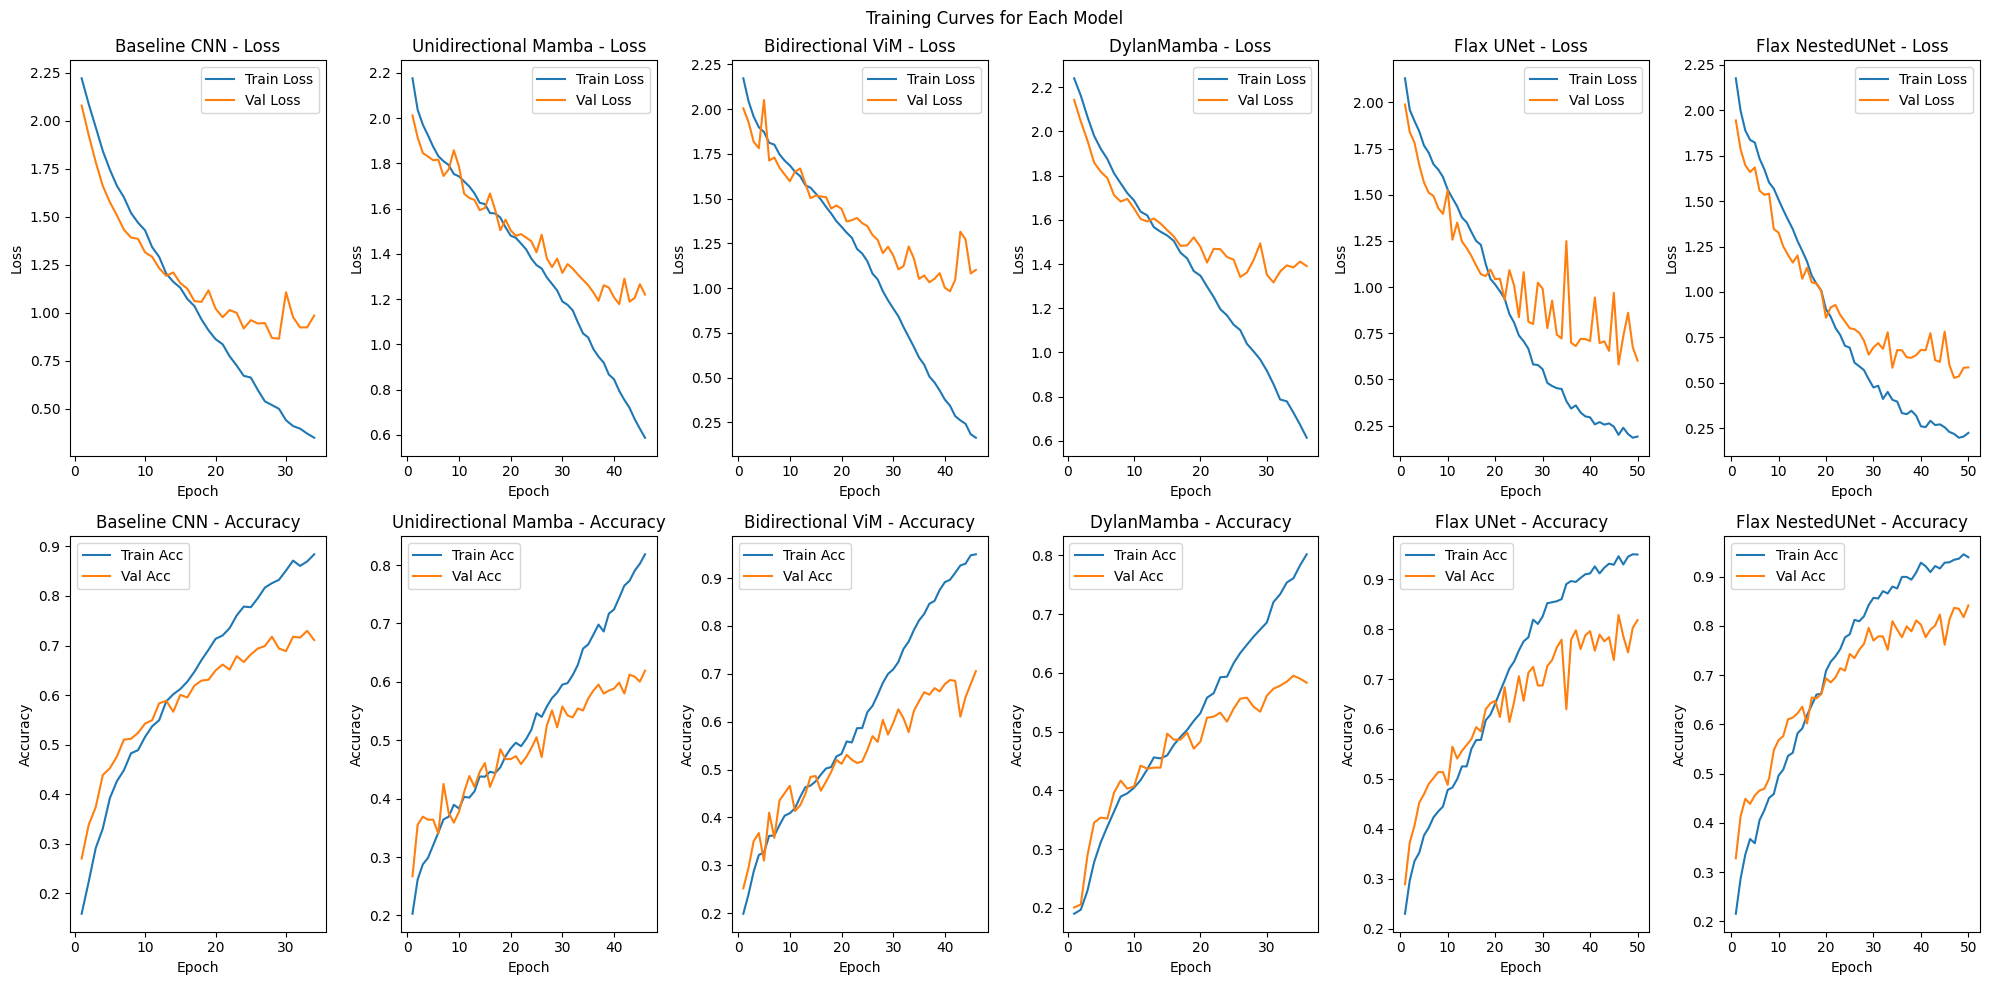

In [ ]:
histories = {
    'Baseline CNN': baseline_history,
    'Unidirectional Mamba': unimamba_history,
    'Bidirectional ViM': bimamba_history,
    'DylanMamba': dylan_history,
    'Flax UNet': flax_unet_history,
    'Flax NestedUNet': flax_nested_history
}

fig, axes = plt.subplots(2, len(histories), figsize=(20, 10))
fig.suptitle('Training Curves for Each Model')

for i, (name, history) in enumerate(histories.items()):
    if history is not None and 'train_loss' in history:
        epochs = range(1, len(history['train_loss']) + 1)

        axes[0, i].plot(epochs, history['train_loss'], label='Train Loss')
        axes[0, i].plot(epochs, history['val_loss'], label='Val Loss')
        axes[0, i].set_title(f'{name} - Loss')
        axes[0, i].set_xlabel('Epoch')
        axes[0, i].set_ylabel('Loss')
        axes[0, i].legend()

        # Dynamically select accuracy keys
        train_acc_key = 'train_accuracy' if 'train_accuracy' in history else 'train_acc'
        val_acc_key = 'val_accuracy' if 'val_accuracy' in history else 'val_acc'
        axes[1, i].plot(epochs, history[train_acc_key], label='Train Acc')
        axes[1, i].plot(epochs, history[val_acc_key], label='Val Acc')
        axes[1, i].set_title(f'{name} - Accuracy')
        axes[1, i].set_xlabel('Epoch')
        axes[1, i].set_ylabel('Accuracy')
        axes[1, i].legend()
    else:
        axes[0, i].text(0.5, 0.5, f'{name}\nNo data', ha='center', va='center', transform=axes[0, i].transAxes)
        axes[1, i].text(0.5, 0.5, f'{name}\nNo data', ha='center', va='center', transform=axes[1, i].transAxes)

plt.tight_layout()
plt.show()

# **Why this project is so f\*\*king hard!!!**